# Graph Traversals

 We discuss two ways of traversing a graph: _Depth First Search_ (DFS) (a recap) and _Breadth First Search_ (BFS).

In [ ]:
%config InteractiveShell.ast_node_interactivity="none"

In [ ]:
!wget https://raw.githubusercontent.com/jamcoders/syllabus-resources-2023/main/week3/lecs/boaz_utils.ipynb
%run "boaz_utils.ipynb"

Earlier, we learned about dictionaries as a new type of datastructure.

We can use them to represent graphs (which you learned about last week)

Here is an example for the graph depicted!

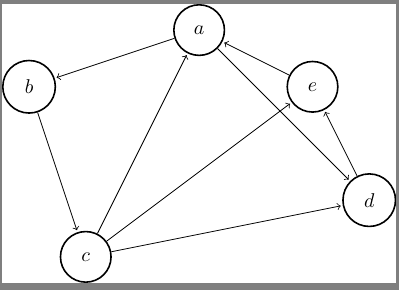


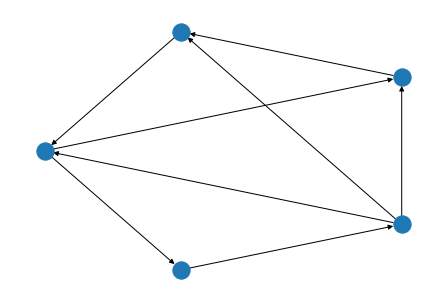

In [ ]:
g1 = {'a': ['b', 'd'],
     'b': ['c'],
     'c': ['a', 'd','e'],
     'd': ['e'],
     'e': ['a']}

# The magic below is just to get a visualization of the graph
G = nx.DiGraph(g1)
draw_graph(G, "shell_layout")

We will want to define standard functions for interacting with our representation (collectively known as an ADT)

In [ ]:
def graph_nodes(graph):
    """Return the set of nodes in graph."""
    return graph.keys()

def graph_nbrs(graph, node):
    """Return the neighbours of node in graph as a list. """
    return list(graph[node])

def graph_size(graph):
    """Return the number of nodes in graph"""
    return len(graph)

**NB:** Technically, we should also define a constructor that would create the dictionary representation explicitly, perhaps a few mutators, and perhaps some predicates for checking properties of the graph, without us having to know that we used a dictionary to represent it.  (This is the point of building an ADT).  But we will ignore those for now.

We can exercise our ADT a bit to check that we implemented it correctly.

In [ ]:
print(f"Graph g1 has {graph_size(g1)} nodes")
print(f"nodes = {graph_nodes(g1)}")
print(f"nbrs of 'c' = {graph_nbrs(g1, 'c')}")

Graph g1 has 5 nodes
nodes = dict_keys(['a', 'b', 'c', 'd', 'e'])
nbrs of 'c' = ['a', 'd', 'e']


## The Task
We want to explore a graph from a given start node and return a list of all the reachable nodes from it.  We also want that list of nodes in the same order in which they were visited during the exploration.

There are a few ways we could go about doing this.  (Let's discuss them)

- Intrepid: Go as far from home as possible, as long as unexplored places continue to be discovered.
    - We refer to this strategy as a **Depth First Search**

- Cautious: Only take a step further from start if we have already explored all places that are nearer.
    - We refer to this strategy as a **Breadth First Search**

## DFS Implementation

Initially no nodes are visited. We will need a way to create a datastructure to represent this for a given graph.  

(Let us use a dictionary)

In [ ]:
def init_visited(graph):
    """Return a dictionary mapping each node in graph to False """
    result = {}
    for node in graph_nodes(graph):
        result[node] = False
    return result



**Ignorable Flex:** We could also write this simpler with a single line using "dictionary comprehension"

In [ ]:
def init_visited2(graph):
    """Return a dictionary mapping each node in graph to False """
    return {node: False for node in graph_nodes(g)}

# Check that the two implementations are equivalent
print (init_visited(g1) == init_visited2(g1))  # We expect this to be True

True


- A DFS traversal starts exploring from a given node.
    - When we explore from a node, we say we have **visited** it.
- If that node has no neighbours, the exploration from there is done
- Otherwise, we want to (recursively explore) from each neighbour so long as it has not already been visited.
- Every time we visit a node, we want to add it to our list of reachable nodes.

Notice that the recursive step needs to know which nodes have been visited, but when we started, we cared only about the start node (and the graph).  So, we will build this with 2 functions: one to get started, the other to carry on recursively.

In [ ]:
# This is just to get started
def dfs_find_reachable(g, start):
    visited = init_visited(g)
    reachable = []
    dfs_explore_reachable(g, start, visited, reachable)
    return reachable

# This one will do the hard work
def dfs_explore_reachable(g, node, visited, reachable):
    visited[node] = True
    reachable.append(node)
    for nbr in graph_nbrs(g, node):
        if not visited[nbr]:
            dfs_explore_reachable(g, nbr, visited, reachable)

In [ ]:
print(dfs_find_reachable(g1, 'a'))

['a', 'b', 'c', 'd', 'e']


## Generalizing the DFS (Optional)
The DFS order of traversing a graph can be used as a subroutine by other algorithms to extract useful information about a graph.  Examples include:
    - Detecting cycles
    - Determining the tree of traversal
    - Determining whether one node will be visited before another
    - Topological sort
    
We can try to analyse the structure of the DFS and generalize it so that the DFS part does not have to be reimplemented for each task.

In [ ]:
def dfs(g, start, actions={
                    'pre_node' : lambda node: None,
                    'post_node' : lambda node: None,
                    'pre_edge' : lambda node: None,
                    'post_edge' : lambda node, nbr : None}):
    visited = init_visited(g)
    dfs_explore(g, start, visited, actions)

def dfs_explore(g, node, visited, actions):
    """Explore g, from node, not revisiting any nodes marked in visited,
    executing pre/post node and edge actions provided in actions.

    actions is a dictionary with 4 keys: 'pre_node', 'post_node',
    'pre_edge', 'post_edge'. Each must be bound to a function.
    Node functions accept a node as an argument
    Edge functions accept as arguments the source and destination nodes
    """
    visited[node] = True
    # Pre-process node here
    actions['pre_node'](node)
    for nbr in graph_nbrs(g, node):
        if not visited[nbr]:
            # Pre-process edge (node, nbr) here
            actions['pre_edge'](node, nbr)
            dfs_explore(g, nbr, visited, actions)
            # Post-process edge (node, nbr) here
            actions['post_edge'](node, nbr)
    # Post-process node here
    actions['post_node'](node)


Let us use this to calculate _start_ and _finish_ times.  We pretend that there is a clock that ticks once whenever we mark the time (so consecutive reading differs by 1).

In [62]:
def start_finish_times(g, node):
    """Return a triple of:
        - a list of nodes in the order visited
        - a dictionary of start times
        - a dictionary of finish times
    which arise when a DFS is initiated from the given node."""

    start = {}
    finish = {}
    sequence = []
    
    # We use a local variable to store the time, so that 
    # it cannot be tampered with by code outside of this function
    clock = {'time':0}
    def get_time():
        result = clock['time']
        clock['time'] += 1
        return result

    def pre_node(node):
        start[node] = get_time()
        sequence.append(node)

    def post_node(node):
        finish[node] = get_time()

    def pre_edge(node, nbr):
        pass   # Do nothing

    def post_edge(node, nbr):
        pass   # Do nothing

    actions = {'pre_node': pre_node, 'post_node': post_node,
               'pre_edge': pre_edge, 'post_edge': post_edge}

    dfs(g, node, actions)
    return (sequence, start, finish)

In [ ]:
print(start_finish_times(g1, 'a'))

(['a', 'b', 'c', 'e', 'd'], {'a': 0, 'b': 1, 'c': 2, 'e': 3, 'd': 4}, {'d': 5, 'e': 6, 'c': 7, 'b': 8, 'a': 9})


## Applications
- Graphs have a very wide range of applications.  
- Even the search techniques we have talked about today are very commonly used as part of bigger algorithms

Any problem in which:
- there are "things" (the **nodes**),
- some of which are related (the **edges**), and
- the solution depends on analysing these relations can probably be usefully represented as a graph.

Studying graph algorithms gives us a way to think about the problem in a useful way that may not have been obvious at the outset.

Let us see how we can use graphs to make a computer play games intelligently


### Game 1: Word Ladders
Given a start and a finish word, each with the same number of letters, change one letter at a time, each time spelling a valid word, to end at the finish word. e.g. to go from `BOAT` to `SAIL`, we could use the following:
 - `BOAT`
 - `GOAT`
 - `GOAD`
 - `GRAD`
 - `GRID`
 - `GRIT`
 - `GAIT`
 - `WAIT`
 - `WAIL`
 - `SAIL`

The aim of the game is to be the player who finds the shortest word ladder between the two words.  (Can you find a shorter one than the example?)

 How could we use graphs to help find a word ladder between any two words?

 - What are the nodes and edges?
 - What search technique would you recommend, why?

### Game 2: Tic-Tac-Toe
(You all know the game)

How could we use graphs to help make a competitive AI player?

- What are the nodes and edges?
- What search technique could we use?